# 3) Analyze and evaluate optimization output - TRAINING PROTOCOLS

This final notebook uses the `runs.pkl` file created in notebook 2 and it analyzes:

- the distance between different feature sets in the parameter space
- the distance between different feature sets in the feature space - training protocols
- the distance between different feature sets in the extracellular signals

In [1]:
import pickle
import pandas as pd
import seaborn as sns
import sys
import shutil

import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import matplotlib.pyplot as plt
from scipy.spatial import distance
import MEAutility as mu
import json
import time
import numpy as np
from tqdm import tqdm
from pathlib import Path

from scipy.stats import kruskal, mannwhitneyu, wilcoxon

import multimodalfitting as mf

%matplotlib notebook

/home/alessio/anaconda3/envs/multi/lib/python3.8/site-packages/igor-0.3-py3.8.egg/igor/util.py:54: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/alessio/anaconda3/envs/multi/lib/python3.8/site-packages/igor-0.3-py3.8.egg/igor/util.py:54: SyntaxWarning: "is" with a literal. Did you mean "=="?


In [2]:
save_fig = False
figure_folder = Path(".") / "figures_hay_ais"

if save_fig:
    figure_folder.mkdir(exist_ok=True)

In [3]:
base_dir = Path("../..")

In [4]:
colors_dict = {"soma": "C0",
               "all": "C1",
               "sections": "C2",
               "single": "C3"}
feature_sets = {"soma": "soma",
                "all": "extra",
                "sections": "extra",
                "single": "extra"}
figsize = (10, 7)

## Load GT params and optimization output

In [5]:
# general
model_name = "hay_ais"
probe_type = "planar" # linear 

cell_models_folder = base_dir / "cell_models"
model_folder = cell_models_folder / model_name
probe_file = model_folder / "fitting" / "efeatures" / "probe_BPO.json"

In [6]:
# change this with folder containing your pkl file
results_date = '220421'  # '211124' '220111' # 
result_folder = base_dir / "results" / results_date

In [7]:
cell = mf.create_ground_truth_model(model_name=model_name,
                                    release=False)
cell_release = mf.create_ground_truth_model(model_name=model_name,
                                            release=True)

probe = mf.define_electrode(probe_file=probe_file)

param_names = [param.name for param in cell.params.values() if not param.frozen]

params_release = {}
for param in cell_release.params_by_names(param_names):
    params_release[param.name] = param.value

In [8]:
protocol_for_eap = "IDrest_300"

In [9]:
pkl_file_name = "runs.pkl"

In [61]:
data = pickle.load(open(result_folder / pkl_file_name, 'rb'))
df_optimization = pd.DataFrame(data)
df_model = df_optimization.query(f"model == '{model_name}'")
# # set strategy column
# df_model.loc[:, "strategy"] = df_model["extra_strategy"].values.copy()
# df_model.loc[df_model["feature_set"] == "soma", "strategy"] = "soma"

strategies = np.unique(df_model.strategy)

opt_results_training = None
results_file = f"opt_results_training_{model_name}.pkl"
if (result_folder / results_file).is_file():
    with open(result_folder / results_file, 'rb') as f:
        opt_results_training = pickle.load(f)

<IPython.core.display.Javascript object>


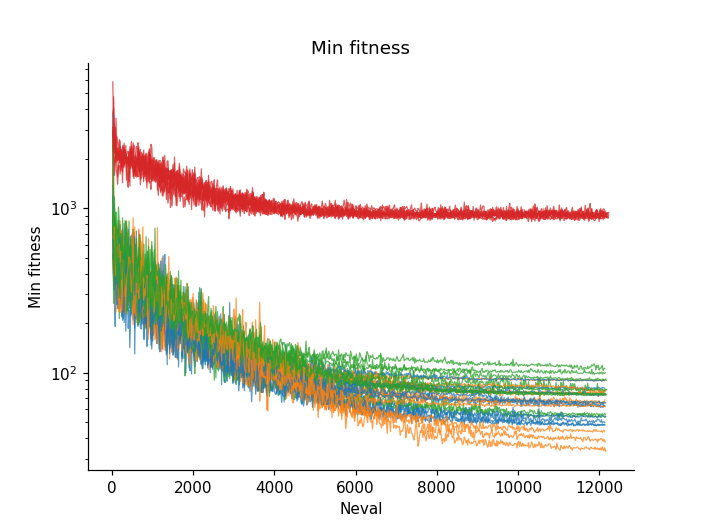

In [11]:
fig, ax = plt.subplots()
min_evals = 3000

keep_idxs = []
for idx, row in df_model.iterrows():
    if max(row["nevals"]) > min_evals:
        keep_idxs.append(idx)
        ax.plot(row["nevals"], 
                row["logbook"].select("min"),
                color=colors_dict[row["strategy"]],
                ls='-', 
                lw=0.8,
                alpha=0.75)
    else:
        ax.plot(row["nevals"], 
                row["logbook"].select("min"),
                color=colors_dict[row["strategy"]],
                ls='--', 
                lw=0.5,
                alpha=0.75)

ax.set_title("Min fitness")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Neval")
ax.set_ylabel("Min fitness")
ax.set_yscale('log')

# Load protocols and original features

In [12]:
extra_kwargs = mf.utils.get_extra_kwargs()
extra_kwargs

{'fs': 20,
 'fcut': [300, 6000],
 'filt_type': 'filtfilt',
 'ms_cut': [3, 5],
 'upsample': 10}

In [14]:
eva_extra = mf.create_evaluator(
    model_name=model_name,
    strategy="all",
    protocols_with_lfp="IDrest_300",
    **extra_kwargs
)

In [15]:
# check num features
for strategy in np.unique(df_model.strategy):
    eva = mf.create_evaluator(
        model_name=model_name,
        strategy=strategy,
        protocols_with_lfp="IDrest_300",
        **extra_kwargs
    )
    print(f"Strategy {strategy} --> num features {len(eva.fitness_calculator.objectives)}")

Strategy all --> num features 87
Strategy sections --> num features 109
Strategy single --> num features 153
Strategy soma --> num features 76


# Compute release responses

In [16]:
responses_release = eva_extra.run_protocols(eva_extra.fitness_protocols.values(), param_values=params_release)

In [17]:
eap_release = mf.utils.calculate_eap(responses=responses_release, protocols=eva_extra.fitness_protocols, 
                                     protocol_name=protocol_for_eap, **extra_kwargs)

In [18]:
features_release = {}
for i in tqdm(np.arange(len(eva_extra.fitness_calculator.objectives)), 
              desc="computing features"):
    obj = eva_extra.fitness_calculator.objectives[i]
    features_release[obj.features[0].name] = {}
    if len(obj.features) == 1:
        feat = obj.features[0]
        feat_value = feat.calculate_feature(responses_release)
        feat_score = feat.calculate_score(responses_release)
        if feat_value is None:
            print(f"{feat.name} cannot be computed: skipping")
            continue
        features_release[feat.name]["value"] = feat_value
    else:
        print(f"More than one feature for objective: {obj.name}")

computing features: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.89it/s]


<IPython.core.display.Javascript object>


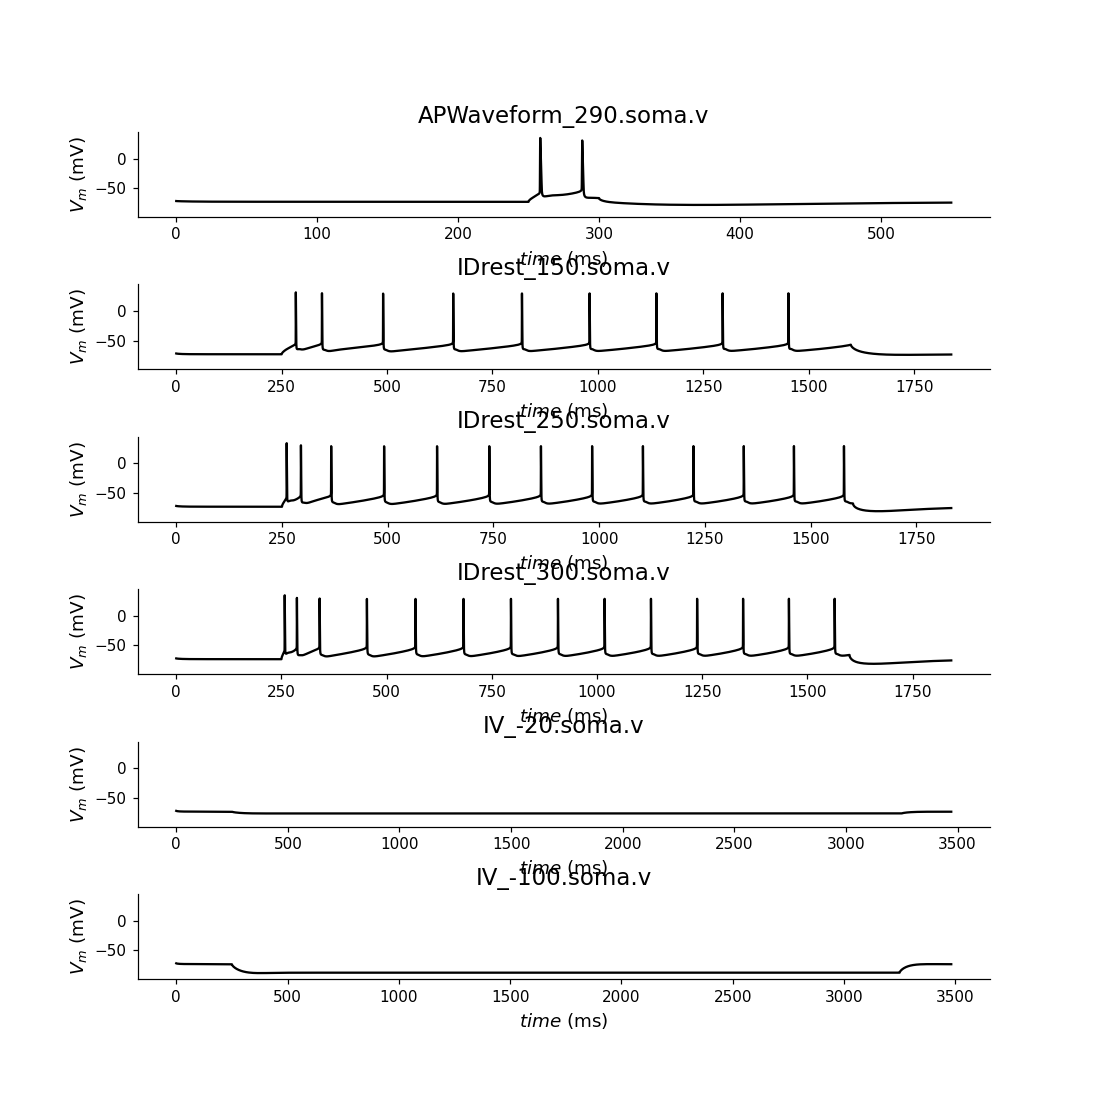

In [19]:
fig_gt_intra = mf.plot_responses(responses_release, color="k", return_fig=True)

<IPython.core.display.Javascript object>


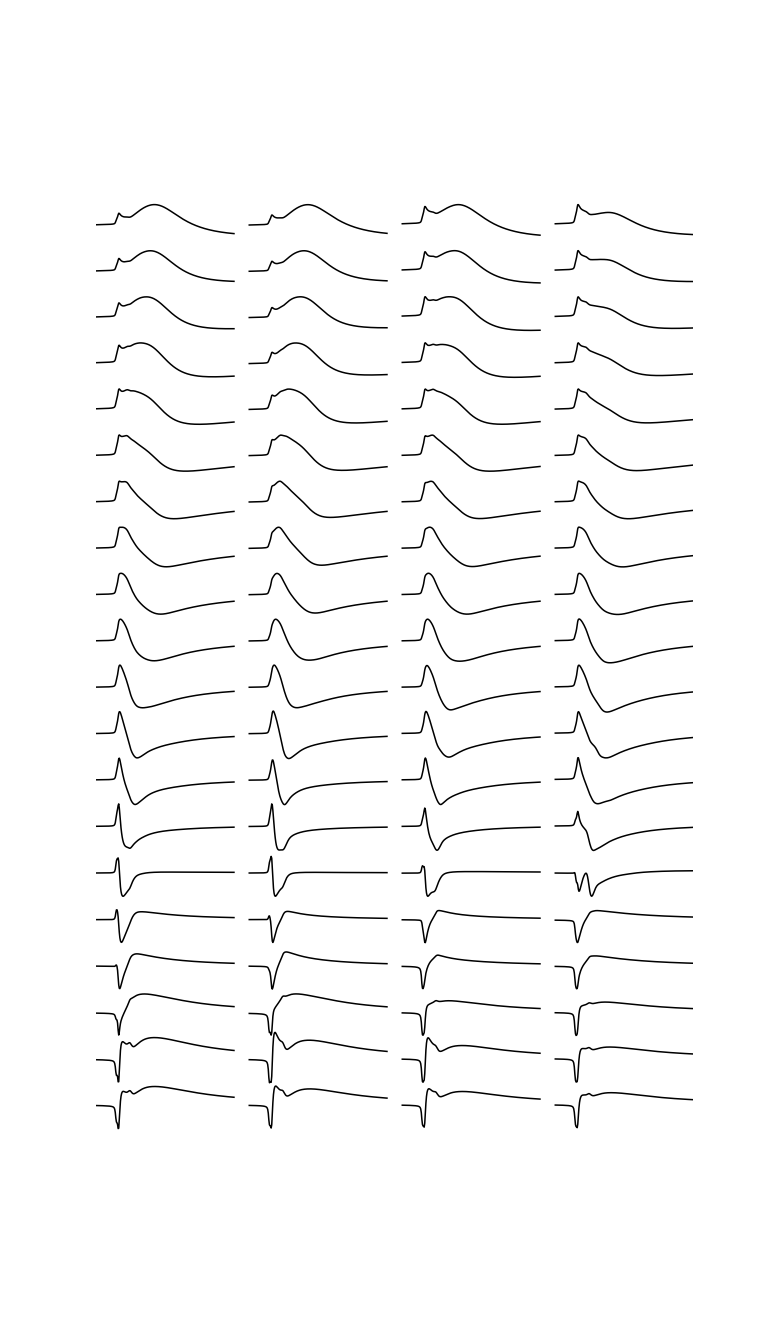

In [20]:
ax = mf.plot_eap(responses_release, eva_extra.fitness_protocols, probe,
                 protocol_name=protocol_for_eap, color="k")
fig_gt_extra = ax.get_figure()

In [ ]:
if save_fig:
    fig_gt_intra.savefig(figure_folder / "gt_intra.pdf", transparent=True)
    fig_gt_extra.savefig(figure_folder / "gt_extra.pdf", transparent=True)

# Compute and plot best responses

In [21]:
max_feature_value = 50
if opt_results_training is None:
    opt_results_training = {}
    compute_responses = True
else:
    compute_responses = False

In [22]:
compute_responses

True

In [23]:
if compute_responses:
    for strategy in strategies:
        print(f"Simulating best '{strategy}'")
        # simulate all responses
        opt_df = df_model.query(f"strategy == '{strategy}'")
        opt_results_training[strategy] = {}

        all_responses = {}
        all_eaps = {}
        all_params = {}
        for idx, row in opt_df.iterrows():
            seed = row.seed
            print("\tSeed", row.seed)
            population = row.population
            scores = [sum(pop.fitness.values) for pop in population]
            best_individual_idx = np.argmin(scores)
            params = population[best_individual_idx]
            params_dict = {k: v for k, v in zip(param_names, params)}
            all_params[seed] = params_dict
            responses_seed = eva_extra.run_protocols(eva_extra.fitness_protocols.values(), 
                                                     param_values=params_dict)
            all_responses[seed] = responses_seed
            eap_seed = mf.utils.calculate_eap(responses=responses_seed, protocols=eva_extra.fitness_protocols, 
                                         protocol_name=protocol_for_eap, **extra_kwargs)
            all_eaps[seed] = eap_seed
        opt_results_training[strategy]["eaps"] = all_eaps
        opt_results_training[strategy]["responses"] = all_responses
        opt_results_training[strategy]["params"] = all_params

Simulating best 'all'
	Seed 5
	Seed 3
	Seed 8
	Seed 10
	Seed 7
	Seed 2
	Seed 9
	Seed 1
	Seed 6
	Seed 4
Simulating best 'sections'
	Seed 5
	Seed 6
	Seed 9
	Seed 10
	Seed 8
	Seed 2
	Seed 7
	Seed 4
	Seed 3
	Seed 1
Simulating best 'single'
	Seed 8
	Seed 4
	Seed 6
	Seed 3
	Seed 5
	Seed 2
	Seed 1
	Seed 10
	Seed 7
	Seed 9
Simulating best 'soma'
	Seed 9
	Seed 8
	Seed 10
	Seed 1
	Seed 3
	Seed 5
	Seed 7
	Seed 2
	Seed 4
	Seed 6


In [24]:
if compute_responses:
    for strategy in opt_results_training:
        features_best = {}
        opt_results_training[strategy]["fitness"] = {}
        for seed, responses in opt_results_training[strategy]["responses"].items():
            extra_fitness = 0
            intra_fitness = 0
            for i in tqdm(np.arange(len(eva_extra.fitness_calculator.objectives)), 
                          desc=f"computing features {strategy}"):
                obj = eva_extra.fitness_calculator.objectives[i]
                feat = obj.features[0]
                features_best[feat.name] = {}
                if len(obj.features) == 1:
                    feat_value = obj.features[0].calculate_feature(responses)
                    feat_score = obj.features[0].calculate_score(responses)
                    if "MEA" in feat.name:
                        extra_fitness += feat_score
                    else:
                        intra_fitness += feat_score
            opt_results_training[strategy]["fitness"][seed] = {"intra": intra_fitness, "extra": extra_fitness, 
                                                               "total": intra_fitness + extra_fitness}
            print("seed", seed)
            print("\tINTRA", intra_fitness)
            print("\tEXTRA", extra_fitness)
            print("\tTOTAL", intra_fitness + extra_fitness)

computing features all: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.77it/s]


seed 5
	INTRA 54.54792689408101
	EXTRA 4.329587546605829
	TOTAL 58.87751444068684


computing features all: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.90it/s]


seed 3
	INTRA 83.55752624333633
	EXTRA 2.4925518721012327
	TOTAL 86.05007811543756


computing features all: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.87it/s]


seed 8
	INTRA 66.22588007535202
	EXTRA 3.0806420847772973
	TOTAL 69.30652216012932


computing features all: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.79it/s]


seed 10
	INTRA 64.00038388774834
	EXTRA 1.5520448417499015
	TOTAL 65.55242872949825


computing features all: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.86it/s]


seed 7
	INTRA 71.55498751753285
	EXTRA 1.4013558894920002
	TOTAL 72.95634340702485


computing features all: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.74it/s]


seed 2
	INTRA 32.93535388047312
	EXTRA 1.9570948300280466
	TOTAL 34.89244871050117


computing features all: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.90it/s]


seed 9
	INTRA 73.46631533473649
	EXTRA 1.5276435630812468
	TOTAL 74.99395889781773


computing features all: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.83it/s]


seed 1
	INTRA 31.399655904765467
	EXTRA 0.7799745849652895
	TOTAL 32.179630489730755


computing features all: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.84it/s]


seed 6
	INTRA 53.96629499571614
	EXTRA 3.4987032150451443
	TOTAL 57.46499821076129


computing features all: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.78it/s]


seed 4
	INTRA 39.00747274787083
	EXTRA 1.9323058188638713
	TOTAL 40.9397785667347


computing features sections: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.69it/s]


seed 5
	INTRA 50.974569384806614
	EXTRA 0.9156420017379324
	TOTAL 51.89021138654454


computing features sections: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.76it/s]


seed 6
	INTRA 68.8035984935977
	EXTRA 2.834185529248111
	TOTAL 71.63778402284582


computing features sections: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.88it/s]


seed 9
	INTRA 61.909450650218666
	EXTRA 2.8522876103665245
	TOTAL 64.76173826058519


computing features sections: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.81it/s]


seed 10
	INTRA 48.581075703191416
	EXTRA 1.1857797769993468
	TOTAL 49.76685548019076


computing features sections: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.92it/s]


seed 8
	INTRA 87.66430594271621
	EXTRA 3.7296728448087415
	TOTAL 91.39397878752496


computing features sections: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.82it/s]


seed 2
	INTRA 52.065020640447216
	EXTRA 4.365288450841933
	TOTAL 56.430309091289146


computing features sections: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.76it/s]


seed 7
	INTRA 66.36927051264566
	EXTRA 2.4206765337333245
	TOTAL 68.78994704637898


computing features sections: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.86it/s]


seed 4
	INTRA 90.65073946610117
	EXTRA 2.0232054546421523
	TOTAL 92.67394492074332


computing features sections: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.91it/s]


seed 3
	INTRA 76.57242601489087
	EXTRA 2.5738255268765915
	TOTAL 79.14625154176746


computing features sections: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.82it/s]


seed 1
	INTRA 64.94215962151944
	EXTRA 2.896992517215513
	TOTAL 67.83915213873495


computing features single: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.89it/s]


seed 8
	INTRA 137.28964407292077
	EXTRA 1.5768738779028715
	TOTAL 138.86651795082363


computing features single: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.74it/s]


seed 4
	INTRA 157.84392427177355
	EXTRA 1.3272357214544352
	TOTAL 159.17115999322797


computing features single: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.88it/s]


seed 6
	INTRA 128.28407414117953
	EXTRA 0.690543958518551
	TOTAL 128.9746180996981


computing features single: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.73it/s]


seed 3
	INTRA 140.9652275343024
	EXTRA 1.5048516657412756
	TOTAL 142.47007920004367


computing features single: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.87it/s]


seed 5
	INTRA 125.79331540023519
	EXTRA 1.2201135996493937
	TOTAL 127.01342899988458


computing features single: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.92it/s]


seed 2
	INTRA 152.93445099606848
	EXTRA 1.5097123193436115
	TOTAL 154.44416331541208


computing features single: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.68it/s]


seed 1
	INTRA 98.6120082717299
	EXTRA 0.8111052716570981
	TOTAL 99.423113543387


computing features single: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.50it/s]


seed 10
	INTRA 137.06100148200605
	EXTRA 0.8120586561899505
	TOTAL 137.873060138196


computing features single: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.88it/s]


seed 7
	INTRA 104.53443572984115
	EXTRA 0.686646665287452
	TOTAL 105.2210823951286


computing features single: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.83it/s]


seed 9
	INTRA 117.05017607021011
	EXTRA 0.9632622858005335
	TOTAL 118.01343835601065


computing features soma: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.88it/s]


seed 9
	INTRA 62.973560536795944
	EXTRA 4.277814770480834
	TOTAL 67.25137530727677


computing features soma: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.87it/s]


seed 8
	INTRA 47.97369801889934
	EXTRA 4.437627448648896
	TOTAL 52.41132546754824


computing features soma: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.82it/s]


seed 10
	INTRA 50.08168063512546
	EXTRA 3.8446806008306806
	TOTAL 53.926361235956136


computing features soma: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.84it/s]


seed 1
	INTRA 48.254801475500486
	EXTRA 4.243874501470384
	TOTAL 52.49867597697087


computing features soma: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 14.05it/s]


seed 3
	INTRA 90.47186937187868
	EXTRA 4.50555336225912
	TOTAL 94.9774227341378


computing features soma: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.90it/s]


seed 5
	INTRA 73.92249340201484
	EXTRA 2.1817735291251683
	TOTAL 76.10426693114


computing features soma: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.94it/s]


seed 7
	INTRA 80.45348407482139
	EXTRA 2.260433418038655
	TOTAL 82.71391749286005


computing features soma: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.82it/s]


seed 2
	INTRA 63.12367426201573
	EXTRA 4.060732974909765
	TOTAL 67.1844072369255


computing features soma: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.85it/s]


seed 4
	INTRA 54.24965804623196
	EXTRA 5.501617067869899
	TOTAL 59.75127511410186


computing features soma: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 13.86it/s]

seed 6
	INTRA 65.9789577099423
	EXTRA 2.8022552560932805
	TOTAL 68.78121296603558


In [25]:
seeds_array = []
strategy_array = []
intra_score_array = []
extra_score_array = []
total_score_array = []

for strategy in opt_results_training:
    for seed, fitness in opt_results_training[strategy]["fitness"].items():
        seeds_array.append(seed)
        strategy_array.append(strategy)
        intra_score_array.append(fitness["intra"])
        extra_score_array.append(fitness["extra"])
        total_score_array.append(fitness["total"])
df_fitness = pd.DataFrame({"seed": seeds_array, "strategy": strategy_array,
                           "intra_score": intra_score_array, "extra_score": extra_score_array, 
                           "total_score": total_score_array})

In [26]:
# best responses are the solutions that minimize extra_score
best_extras = df_fitness.iloc[df_fitness.groupby("strategy")["extra_score"].idxmin()]
best_extras

seed  strategy  intra_score  extra_score  total_score
7      1       all    31.399656     0.779975    32.179630
10     5  sections    50.974569     0.915642    51.890211
28     7    single   104.534436     0.686647   105.221082
35     5      soma    73.922493     2.181774    76.104267

In [29]:
order_full = ["soma", "all", "sections", "single"]
order = []
for strategy in order_full:
    if strategy in opt_results_training:
        order.append(strategy)

<IPython.core.display.Javascript object>


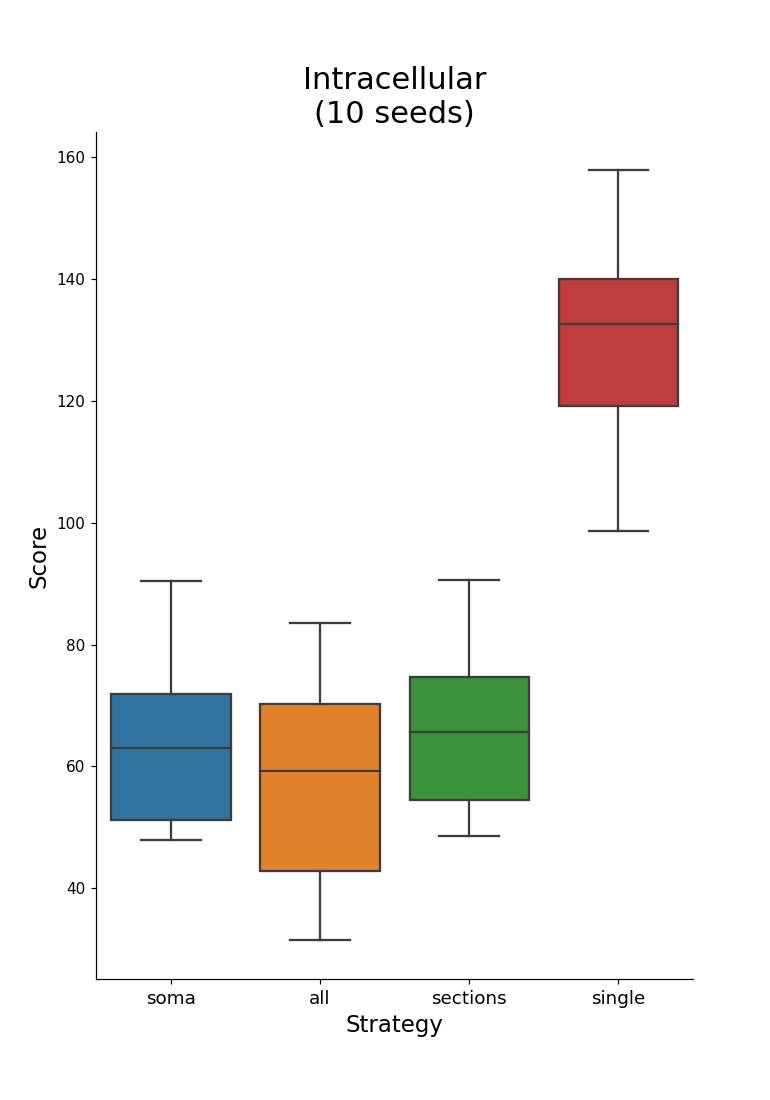

<IPython.core.display.Javascript object>


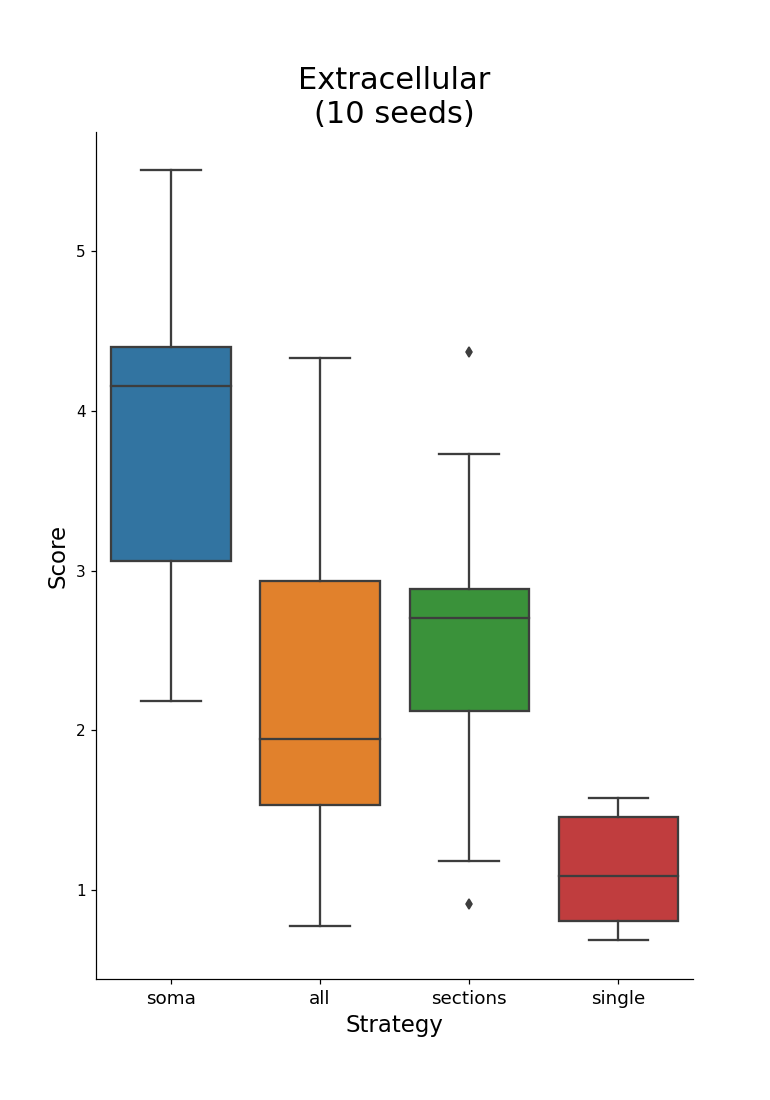

Text(0.5, 1.0, 'Extracellular\n(10 seeds)')

In [30]:
fig_intra_seeds, ax = plt.subplots(figsize=(7, 10))
sns.boxplot(data=df_fitness, x="strategy", y="intra_score", order=order, ax=ax,
            palette=colors_dict)
ax.set_xlabel("Strategy", fontsize=15)
ax.set_ylabel("Score", fontsize=15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_title("Intracellular\n(10 seeds)", fontsize=20)

fig_extra_seeds, ax = plt.subplots(figsize=(7, 10))
sns.boxplot(data=df_fitness, x="strategy", y="extra_score", order=order,
            palette=colors_dict)
ax.set_xlabel("Strategy", fontsize=15)
ax.set_ylabel("Score", fontsize=15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_title("Extracellular\n(10 seeds)", fontsize=20)

In [31]:
if save_fig:
    fig_intra_seeds.savefig(figure_folder / "intra_seed.pdf")
    fig_extra_seeds.savefig(figure_folder / "extra_seed.pdf")    

In [32]:
for idx, row in best_extras.iterrows():
    strategy = row["strategy"]
    seed = row["seed"]
    print("Strategy", strategy, "best seed", seed)
    responses = opt_results_training[strategy]["responses"][seed]
    eap = opt_results_training[strategy]["eaps"][seed]
    params = opt_results_training[strategy]["params"][seed]
    opt_results_training[strategy]["best_seed"] = seed
    opt_results_training[strategy]["best_responses"] = responses
    opt_results_training[strategy]["best_eap"] = eap
    opt_results_training[strategy]["best_params"] = params
    eap_release_norm = eap_release / np.ptp(np.abs(eap_release), 1, keepdims=True)
    eap_norm = eap / np.ptp(np.abs(eap), 1, keepdims=True)
    eap_dist = np.sum(np.abs(eap_release_norm.ravel() - eap_norm.ravel()))
    opt_results_training[strategy]["best_eap_dist"] = eap_dist
    print(eap_dist)

Strategy all best seed 1
236.27190462687963
Strategy sections best seed 5
290.2476505132186
Strategy single best seed 7
211.52583265592216
Strategy soma best seed 5
749.3250528838744


In [33]:
if compute_responses:
    for strategy in np.unique(df_model.strategy):
        responses = opt_results_training[strategy]["best_responses"]
        features_best = {}
        for i in tqdm(np.arange(len(eva_extra.fitness_calculator.objectives)), 
                      desc=f"computing features {strategy}"):
            obj = eva_extra.fitness_calculator.objectives[i]
            feat = obj.features[0]
            features_best[feat.name] = {}
            if len(obj.features) == 1:
                feat_value = obj.features[0].calculate_feature(responses)
                if feat_value is None:
                    feat_value = max_feature_value
                features_best[feat.name]["value"] = feat_value
                if "MEA" not in feat.name:
                    feat_score = np.abs(features_release[feat.name]["value"] - feat_value) / feat.exp_std
                else:
                    feat_score = np.abs(distance.cosine(features_release[feat.name]["value"], feat_value))
                features_best[feat.name]["score"] = feat_score
            else:
                print(f"More than one feature for objective: {obj.name}")
        opt_results_training[strategy]["features"] = features_best

computing features soma: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:03<00:00, 28.09it/s]


<IPython.core.display.Javascript object>


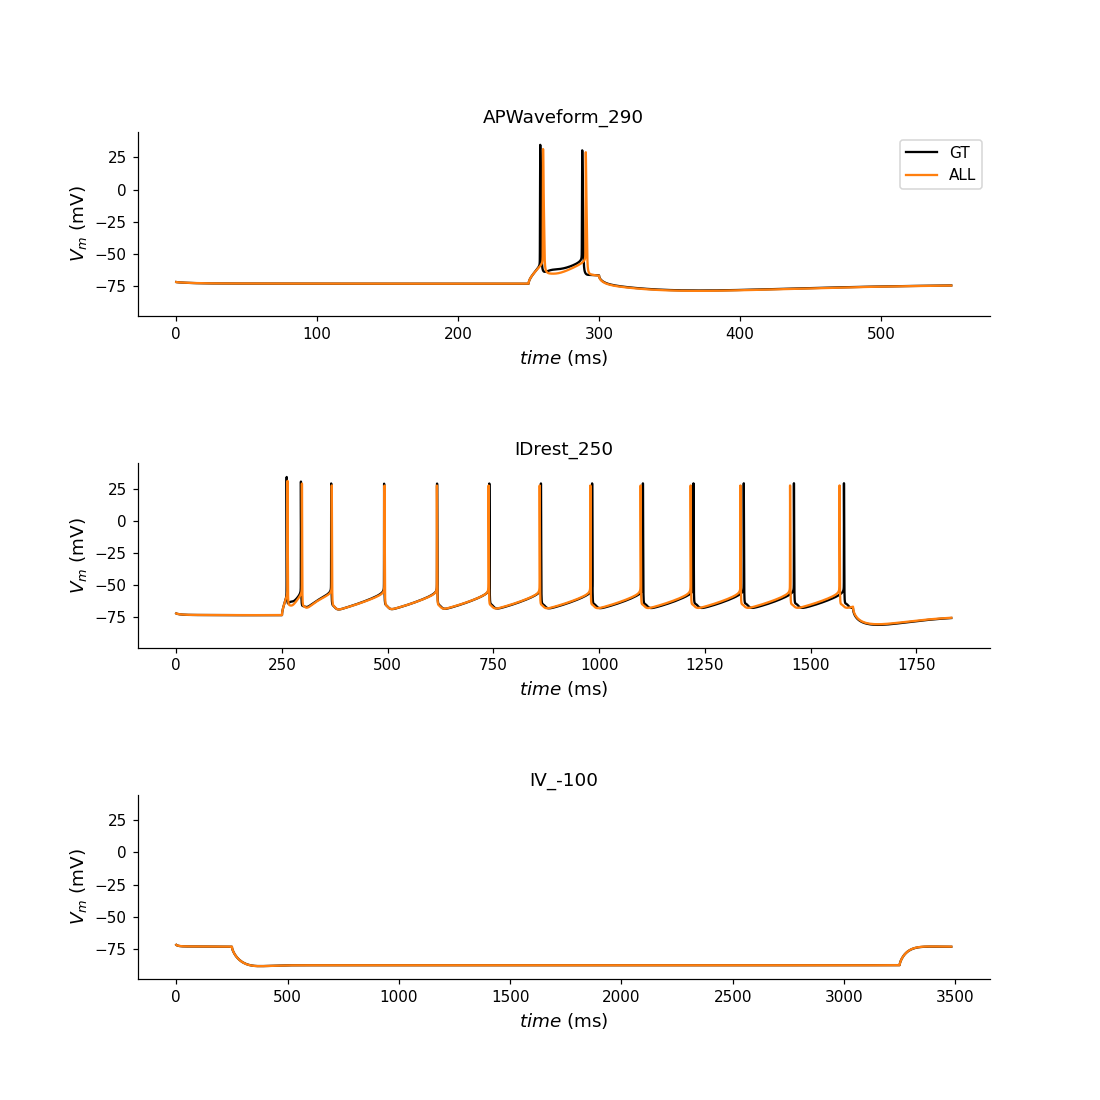

<IPython.core.display.Javascript object>


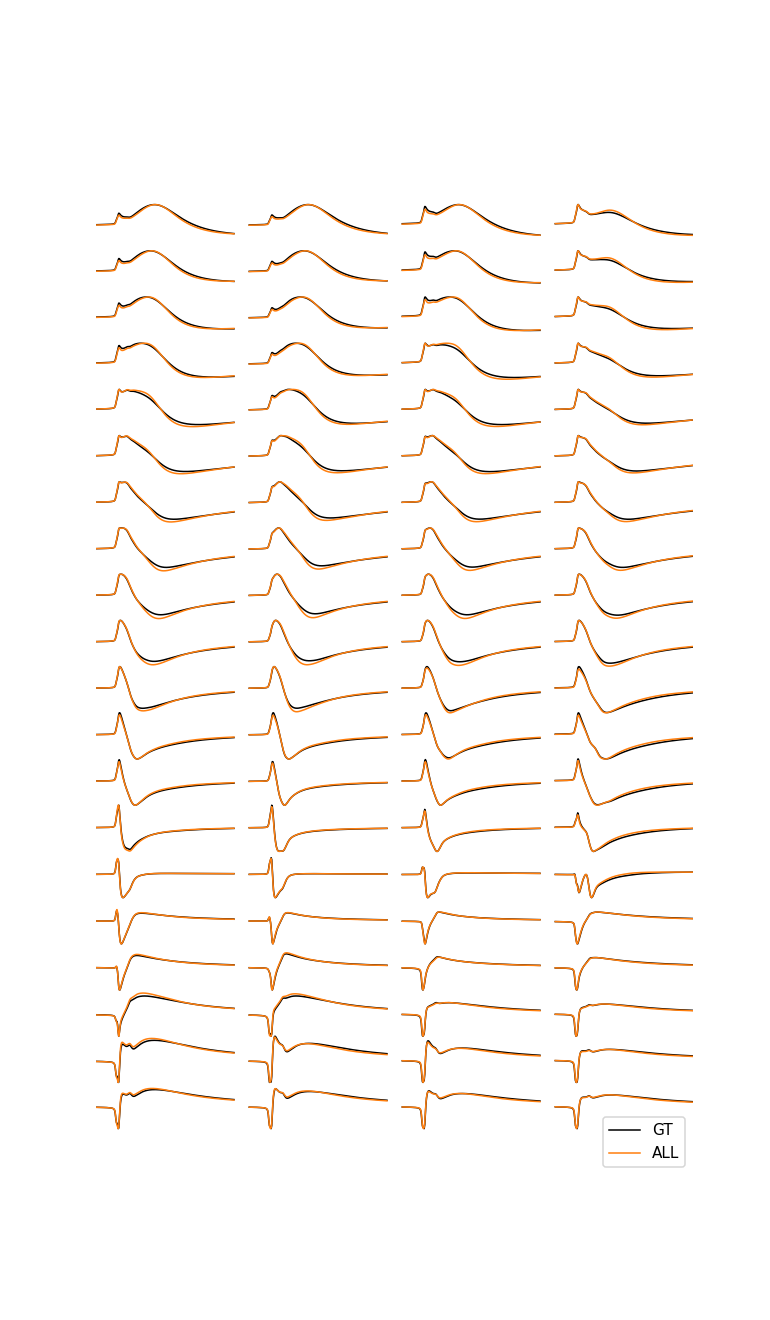

<IPython.core.display.Javascript object>


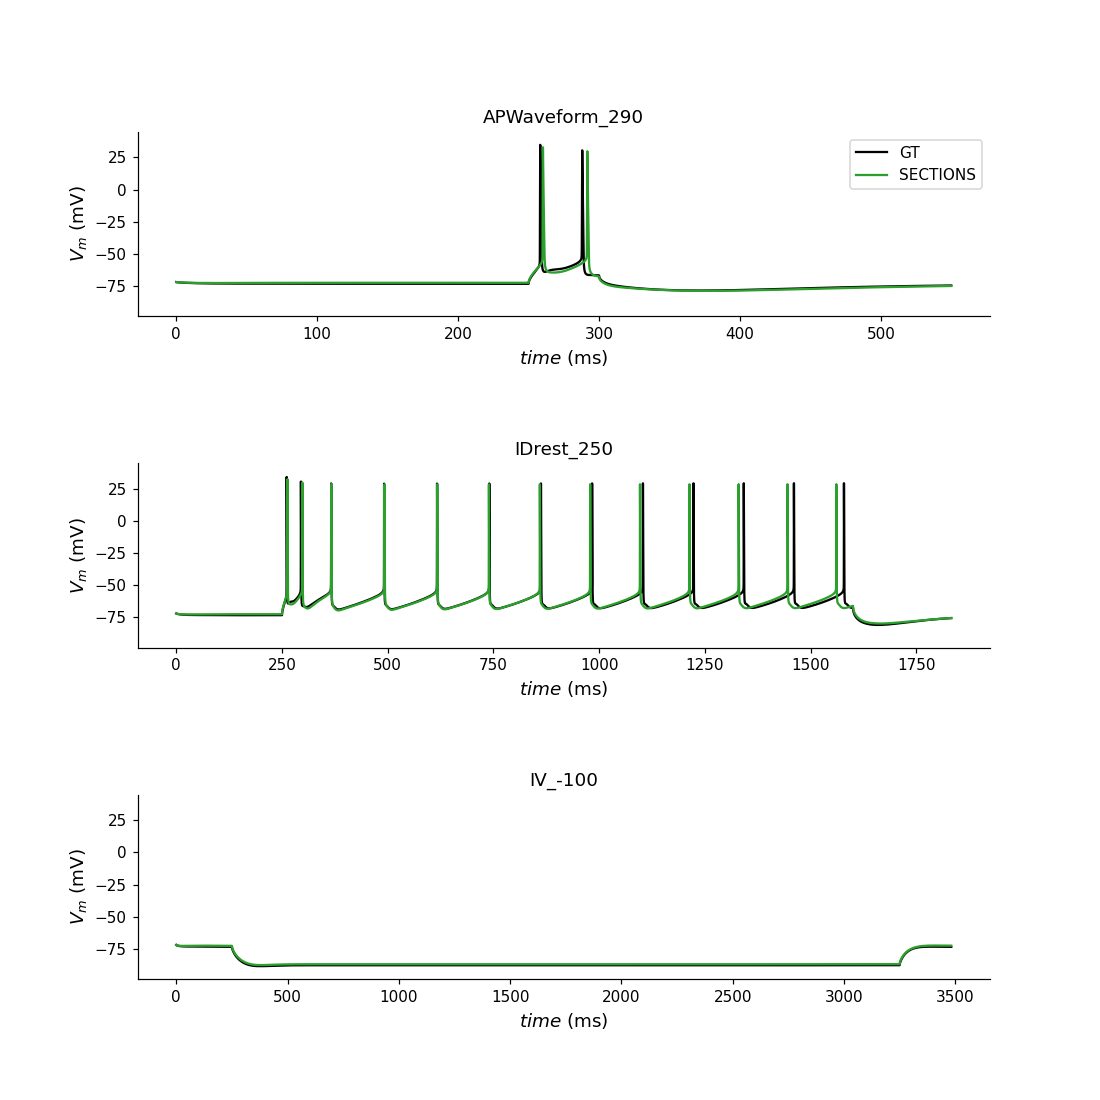

<IPython.core.display.Javascript object>


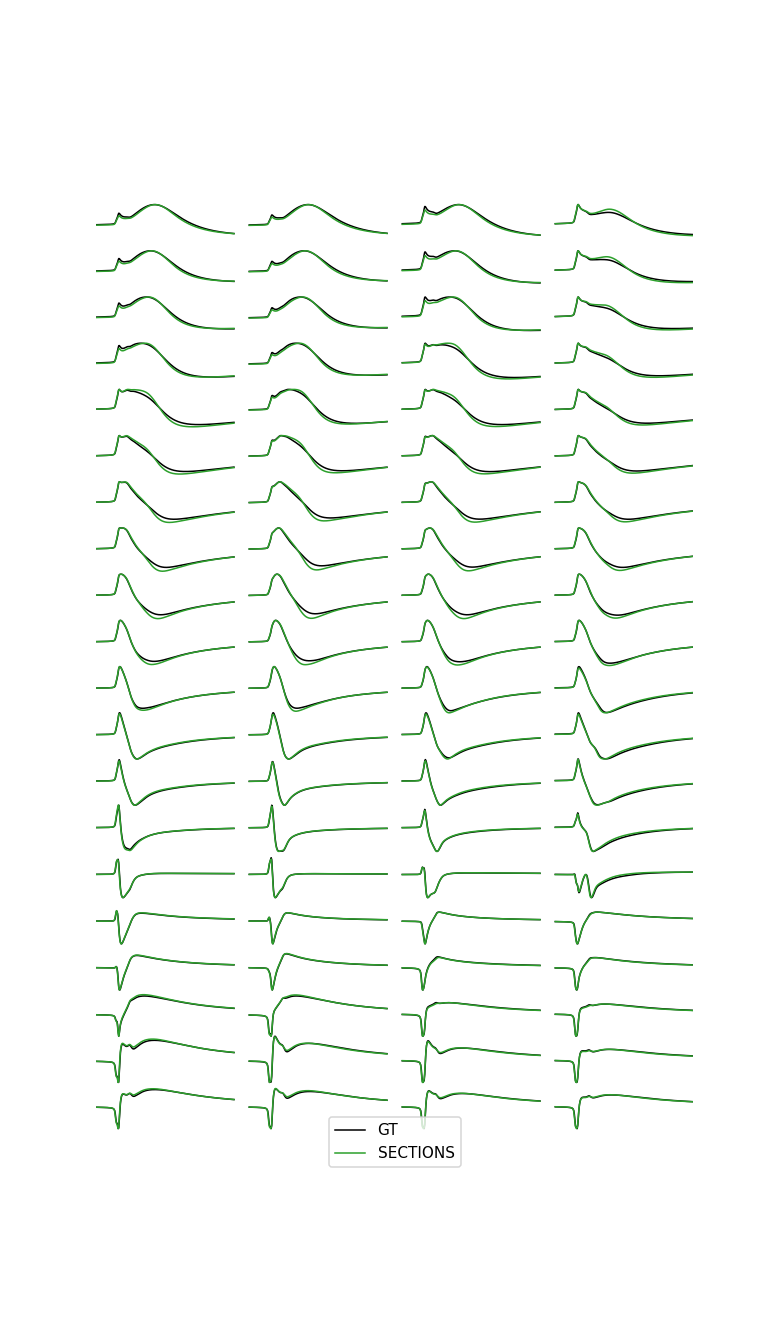

<IPython.core.display.Javascript object>


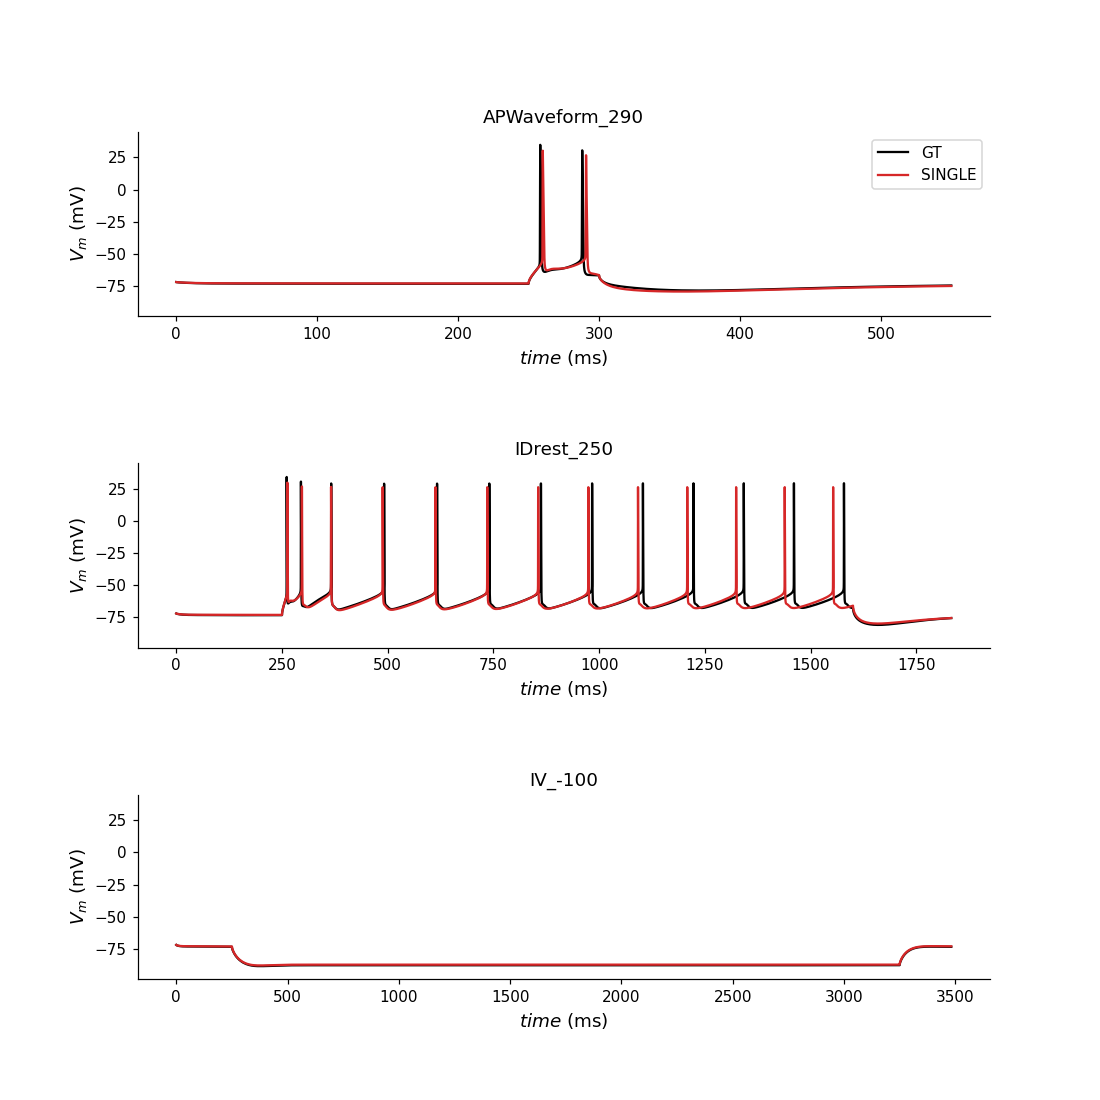

<IPython.core.display.Javascript object>


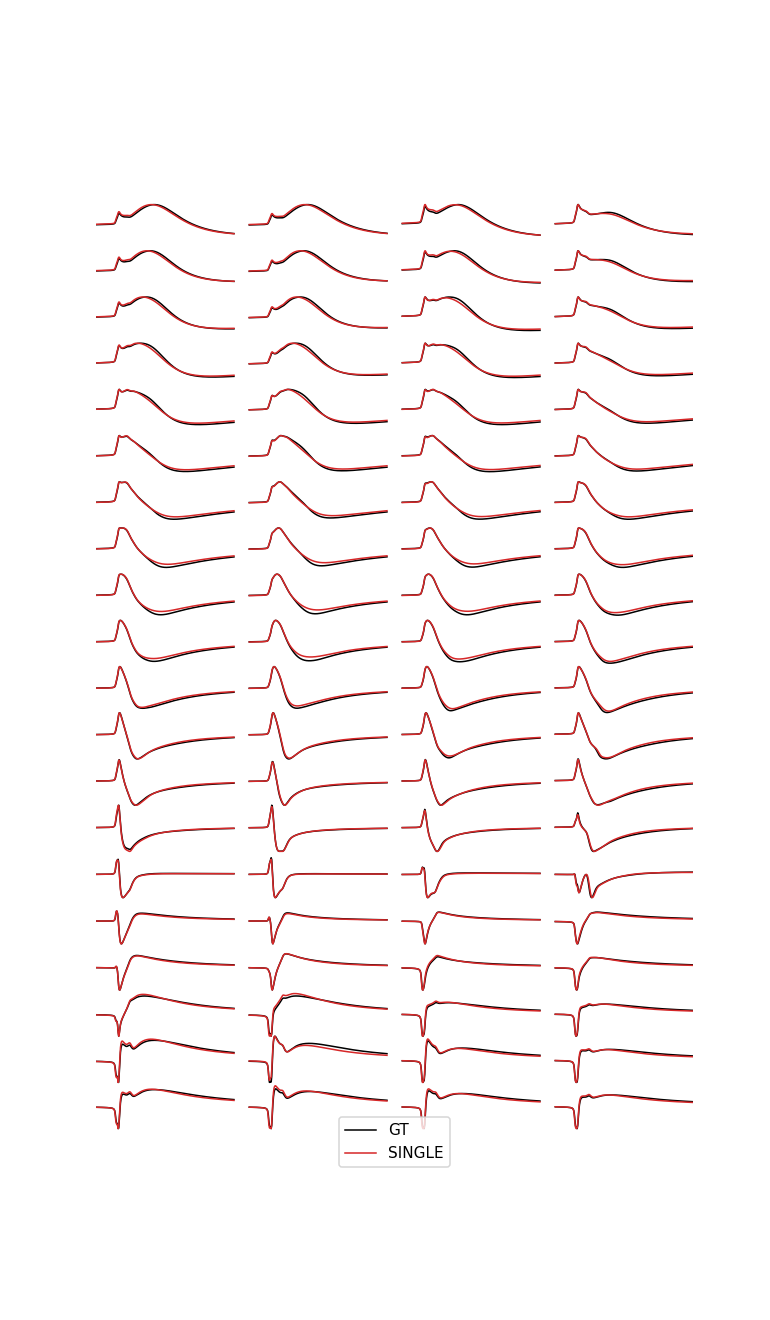

<IPython.core.display.Javascript object>


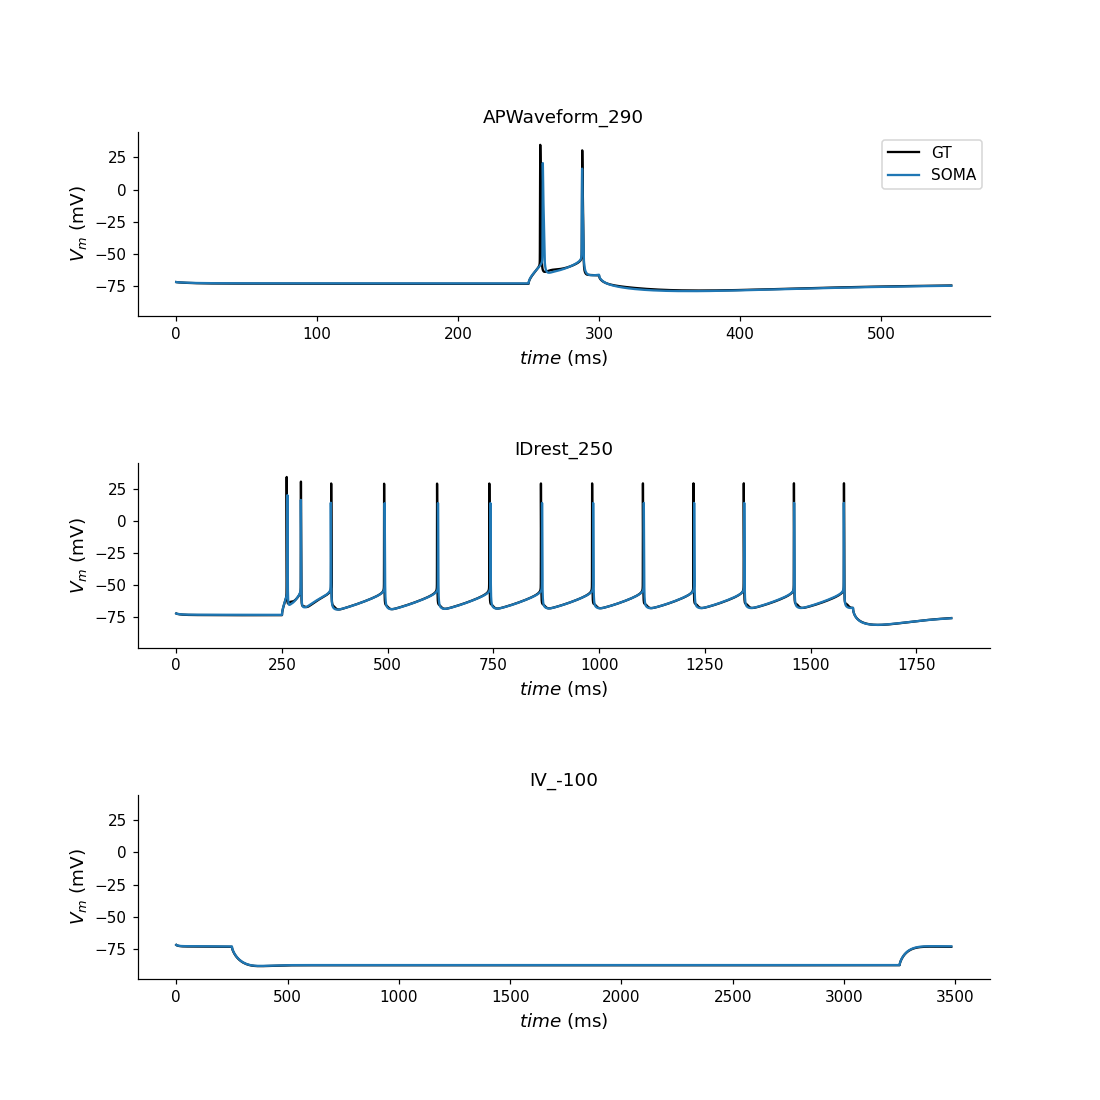

<IPython.core.display.Javascript object>


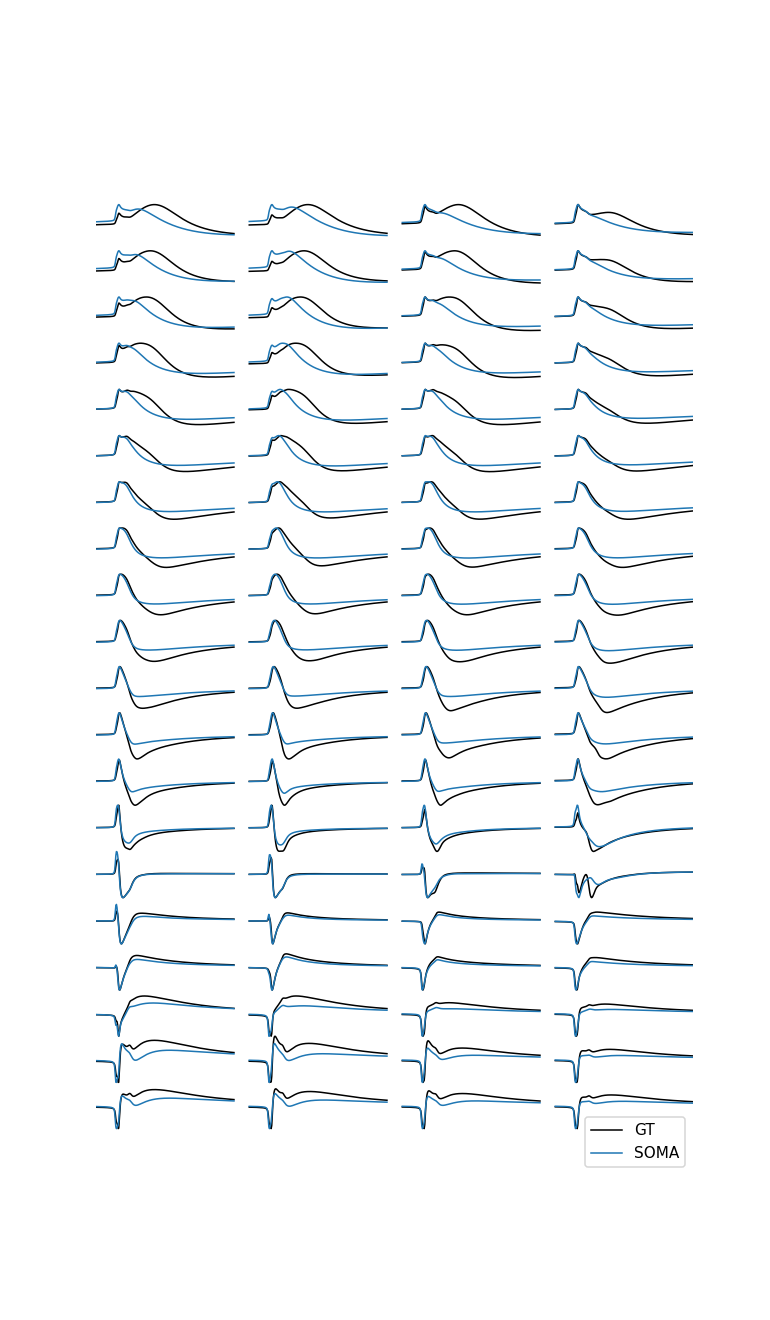

In [34]:
# plot
figs_intra = {}
figs_extra = {}
protocols_to_plot = ["APWaveform_290", "IDrest_250", "IV_-100"]
titles = protocols_to_plot
for strategy in np.unique(df_model.strategy):
    responses_to_plot = [responses_release, opt_results_training[strategy]["best_responses"]]
    colors = ["k", colors_dict[strategy]]
    labels = ["GT", strategy.upper()]
    fig_intra = mf.plot_multiple_responses(responses_to_plot, 
                                           protocol_names=protocols_to_plot,
                                           colors=colors, 
                                           titles=titles,
                                           return_fig=True, 
                                           labels=labels)
    ax_extra = mf.plot_multiple_eaps(responses_to_plot, 
                                     eva_extra.fitness_protocols, probe,
                                     protocol_name=protocol_for_eap, 
                                     colors=colors, labels=labels, norm=True)
    fig_extra = ax_extra.get_figure()
    figs_intra[strategy] = fig_intra
    figs_extra[strategy] = fig_extra

In [35]:
for strategy in opt_results_training:
    print(f"Distance {strategy}: {opt_results_training[strategy]['best_eap_dist']}")

Distance all: 236.27190462687963
Distance sections: 290.2476505132186
Distance single: 211.52583265592216
Distance soma: 749.3250528838744


In [36]:
if save_fig:
    for strategy, fig in figs_intra.items():
        fig.savefig(figure_folder / f"{strategy}_intra.pdf", transparent=True)
    for strategy, fig in figs_extra.items():
        fig.savefig(figure_folder / f"{strategy}_extra.pdf", transparent=True)

### Save optimization results 

In [37]:
opt_results_training["gt"] = {}
opt_results_training["gt"]["responses"] = responses_release
opt_results_training["gt"]["eap"] = eap_release

In [38]:
with open(result_folder / results_file, 'wb') as f:
    pickle.dump(opt_results_training, f, protocol=pickle.HIGHEST_PROTOCOL)

## Compare best-fitted models

In [39]:
df_test = pd.DataFrame.from_dict(opt_results_training, orient="index")
df_test["strategy"] = df_test.index

## Compare parameters 

Here we normalize the parameters based on the boundaries and compute the relative difference to GT.

In [40]:
param_json = model_folder / "parameters.json"

with param_json.open() as f:
    params = json.load(f)

param_boundaries = {}
for param in params:
    if "bounds" in param:
        if isinstance(param['sectionlist'], list):
            for sec in param['sectionlist']:
                param_boundaries[f"{param['param_name']}_{sec}"] = param["bounds"]
        else:
            sec = param['sectionlist']
            param_boundaries[f"{param['param_name']}_{sec}"] = param["bounds"]

# scale params_release by boundaries
params_release_norm = {}
for param_name, param_val in params_release.items():
    bounds = param_boundaries[param_name]
    param_norm = (param_val - bounds[0]) / (bounds[1] - bounds[0])
    params_release_norm[param_name] = param_norm

In [46]:
feature_set_array = []
param_name_array = []
param_value_array = []
param_norm_array = []
release_value_array = []
release_norm_array = []
diff_with_release_array = []
section_array = []

for i, (index, opt) in enumerate(df_test.iterrows()):
    if opt.strategy in strategies:
        params_dict = opt.best_params

        for param_name, param_value in params_dict.items():
            feature_set_array.append(opt.strategy)
            param_name_array.append(param_name)
            param_value_array.append(param_value)
            section = param_name.split("_")[-1]
            if section == "segment":
                section = "ais"
            section_array.append(section)
            release_value_array.append(params_release[param_name])
            release_norm_array.append(params_release_norm[param_name])
            # compute norm value
            bounds = param_boundaries[param_name]
            param_norm = (param_value - bounds[0]) / (bounds[1] - bounds[0])
            param_norm_array.append(param_norm)
            diff_with_release = np.abs(param_value - params_release[param_name]) / params_release[param_name]
            diff_with_release_array.append(diff_with_release)

        
df_params = pd.DataFrame({"strategy": feature_set_array, "param_name": param_name_array,
                          "param_value": param_value_array, "param_norm": param_norm_array, 
                          "release_value": release_value_array, "release_norm": release_norm_array,
                          "diff_release": diff_with_release_array, "section": section_array}) 

<IPython.core.display.Javascript object>


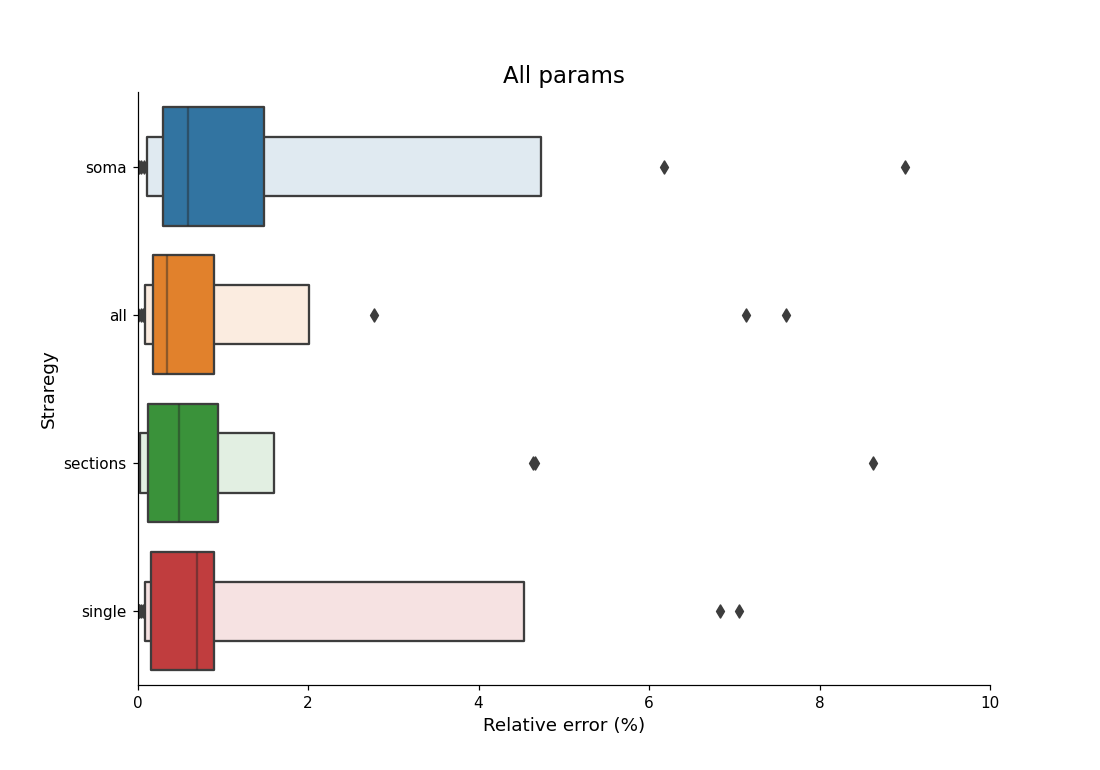

(0.0, 10.0)

In [47]:
# overall parameter diff
fig, ax = plt.subplots(figsize=figsize)
sns.boxenplot(data=df_params, y="strategy", x="diff_release", ax=ax, order=order,
              palette=colors_dict)
ax.set_xlabel("Relative error (%)", fontsize=12)
ax.set_ylabel("Straregy", fontsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("All params", fontsize=15)
ax.set_xlim(0, 10)


<IPython.core.display.Javascript object>


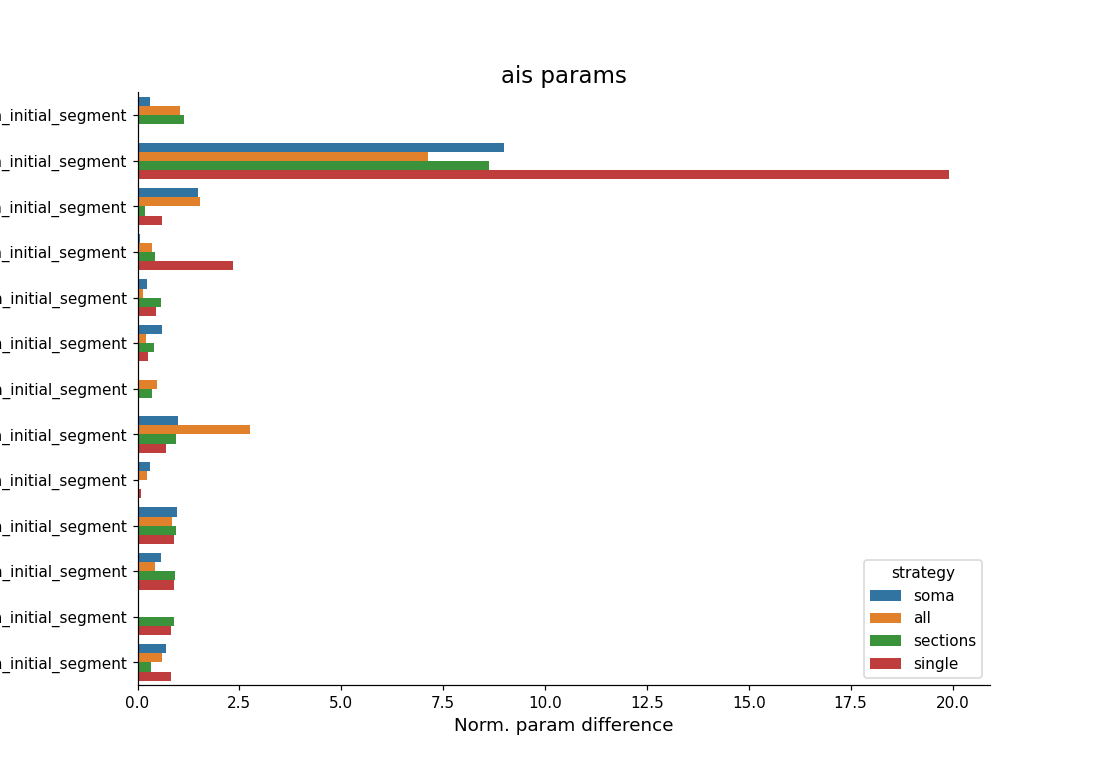

<IPython.core.display.Javascript object>


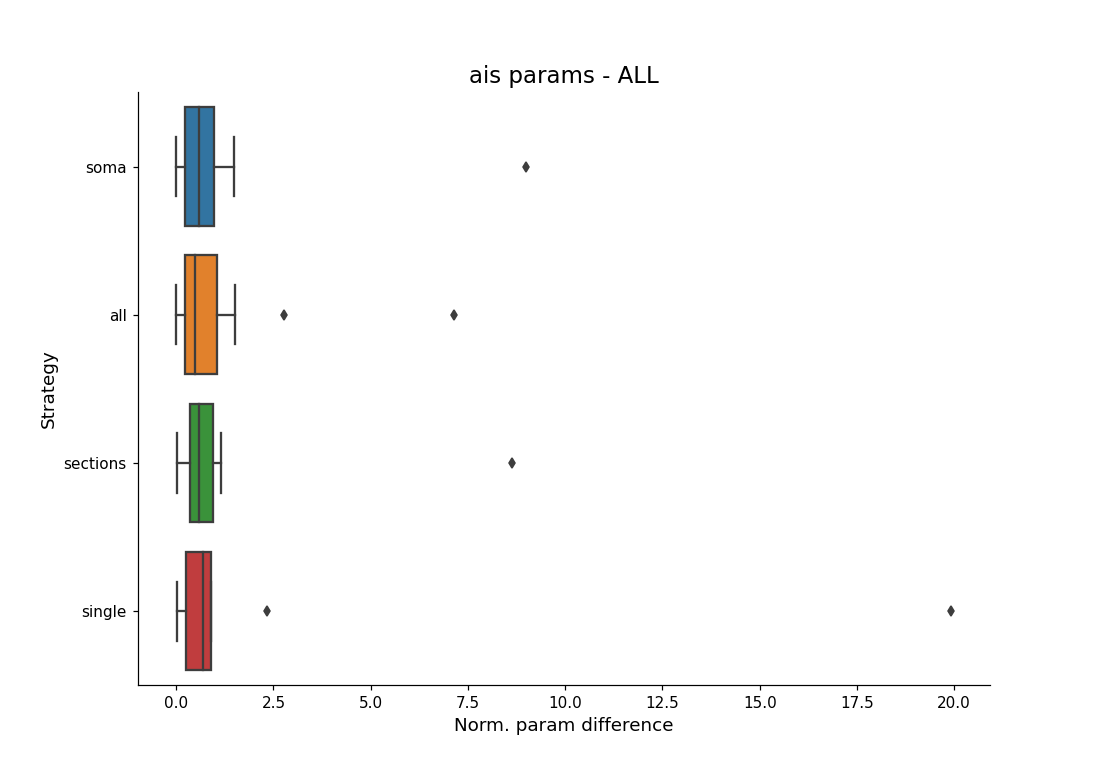

<IPython.core.display.Javascript object>


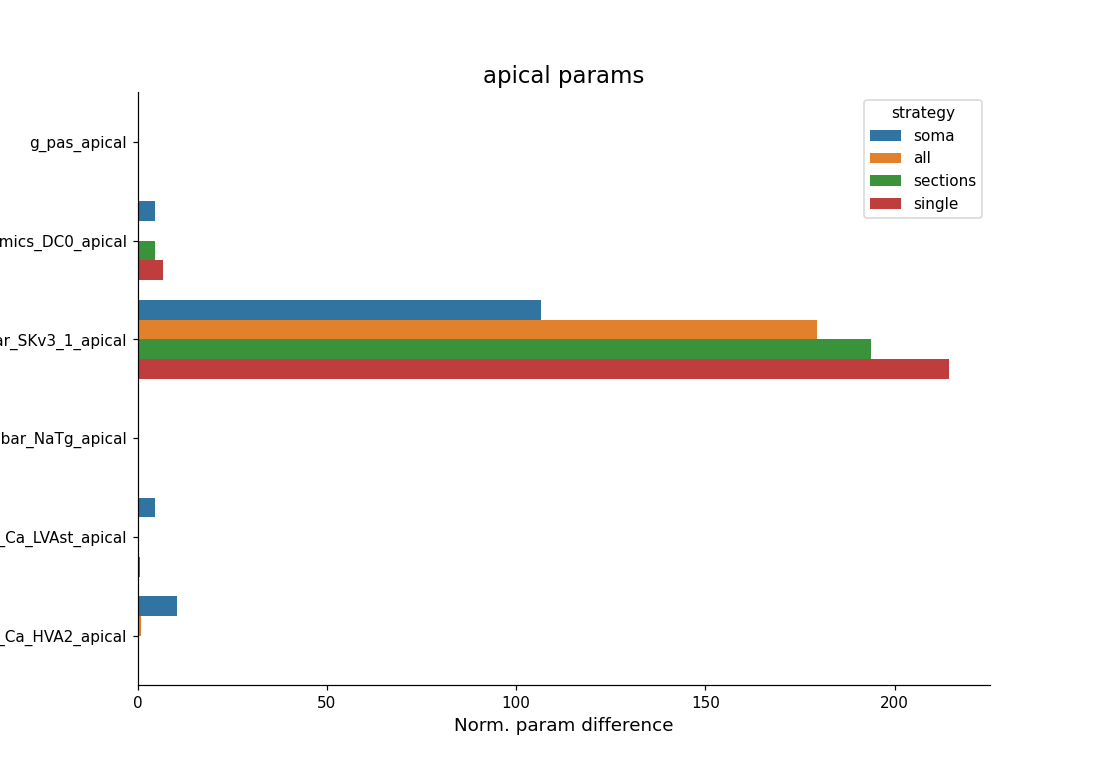

<IPython.core.display.Javascript object>


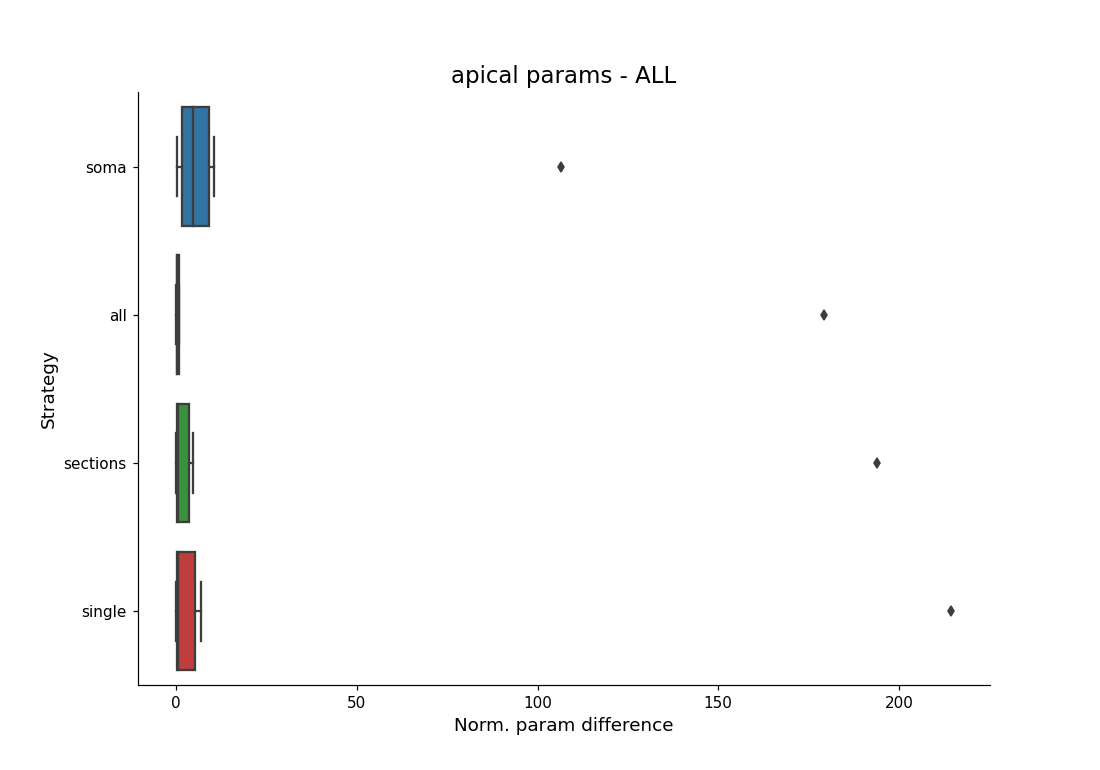

<IPython.core.display.Javascript object>


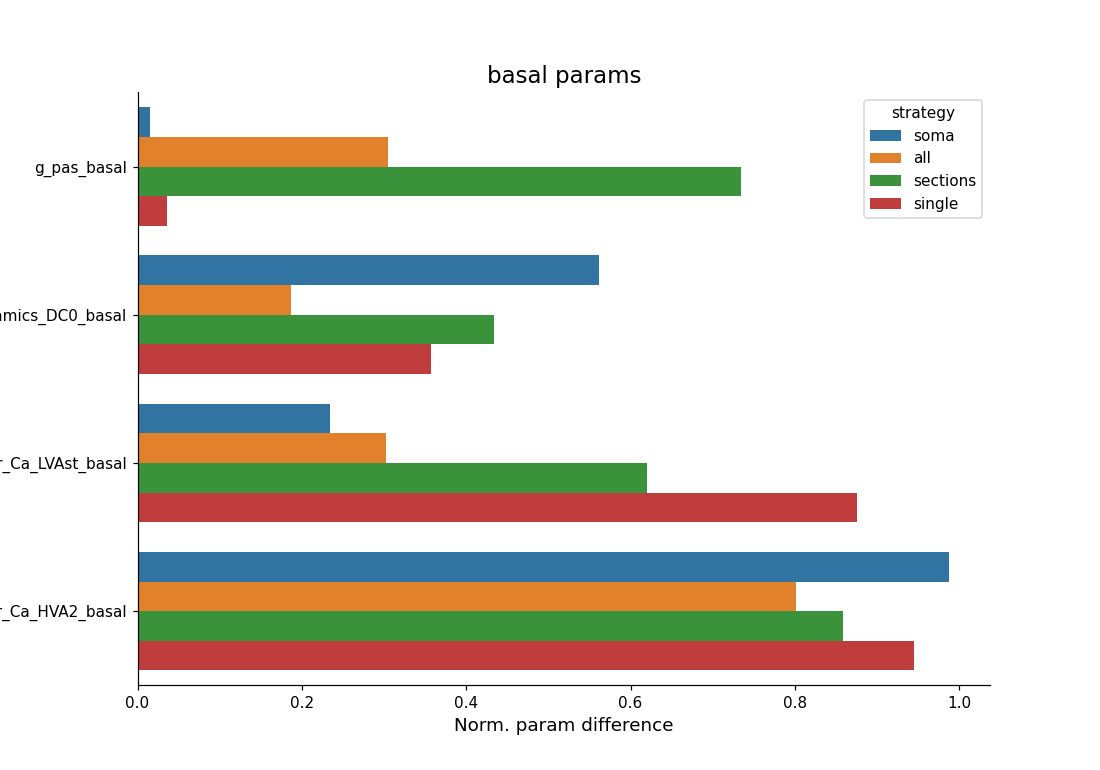

<IPython.core.display.Javascript object>


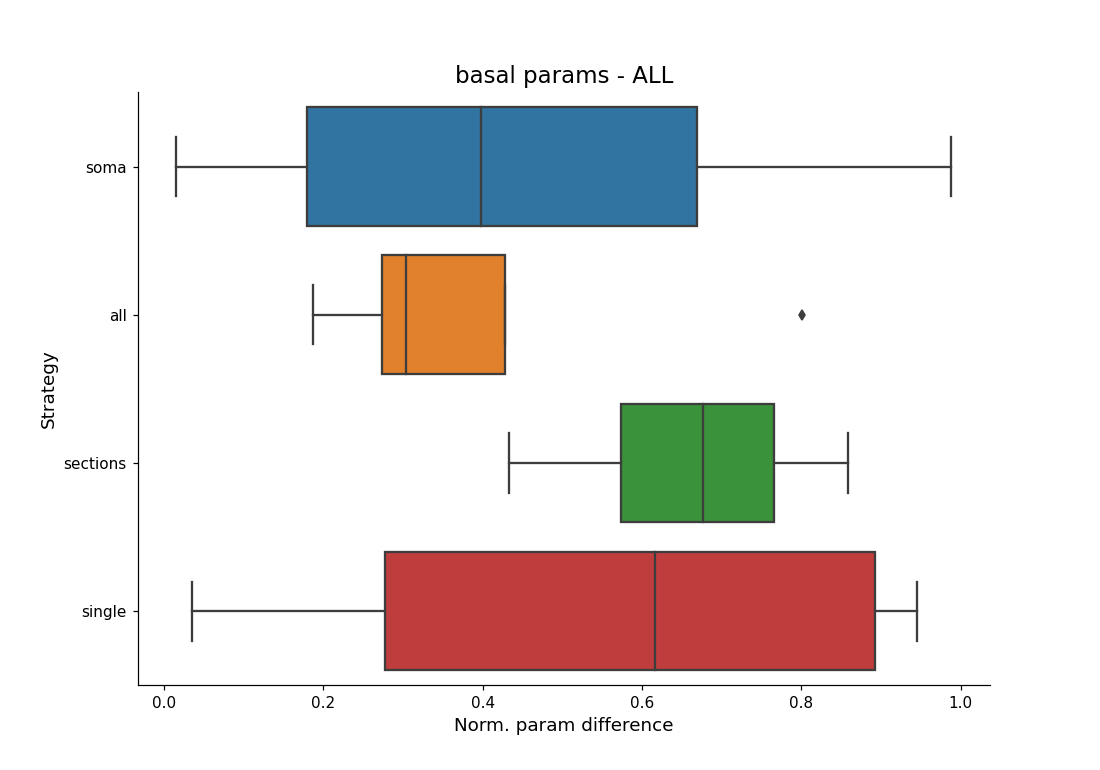

/tmp/ipykernel_4002298/1412225145.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots(figsize=figsize)


<IPython.core.display.Javascript object>


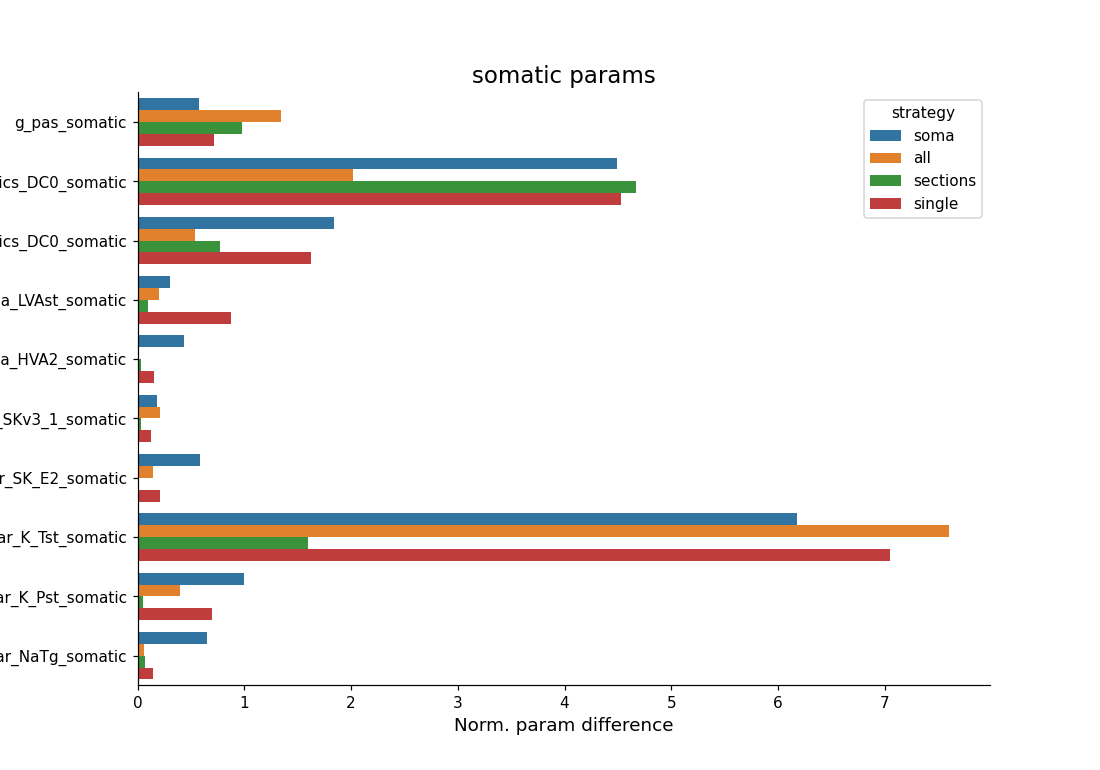

<IPython.core.display.Javascript object>


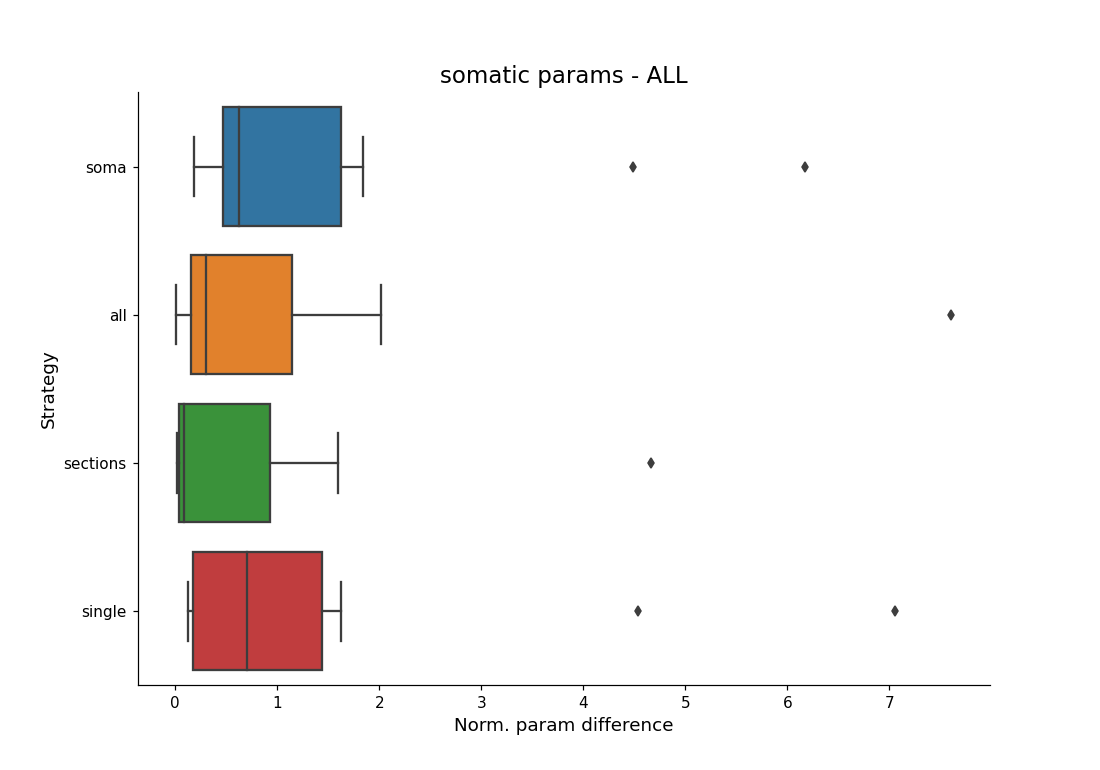

In [48]:
for section in np.unique(df_params.section):
    fig, ax1 = plt.subplots(figsize=figsize)
    df_section = df_params.query(f"section == '{section}'")
    sns.barplot(data=df_section, y="param_name", x="diff_release", hue="strategy",
                orientation="horizontal", ax=ax1, hue_order=order)
    ax1.set_xlabel("Norm. param difference", fontsize=12)
    ax1.set_ylabel("Param", fontsize=12)
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.set_title(f"{section} params", fontsize=15)
    
    fig, ax2 = plt.subplots(figsize=figsize)
    sns.boxplot(data=df_section, y="strategy", x="diff_release", ax=ax2, order=order)
    ax2.set_xlabel("Norm. param difference", fontsize=12)
    ax2.set_ylabel("Strategy", fontsize=12)
    ax2.spines["top"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.set_title(f"{section} params - ALL", fontsize=15)

## Compare features

In [50]:
feature_name_array = []
feature_set_array = []
feature_score_array = []
feature_type_array = []

for strategy, res in opt_results_training.items():
    if strategy in strategies:
        feats = res["features"]
        for feat_name, feat_dict in feats.items():
            feature_set_array.append(strategy)
            feature_name_array.append(feat_name)
            if "MEA" not in feat_name:
                feature_type_array.append("intra")
            else:
                feature_type_array.append("extra")
            feature_score_array.append(feat_dict["score"])
        
df_feats = pd.DataFrame({"feature_set": feature_set_array, "feat_name": feature_name_array,
                         "feat_score": feature_score_array, "feature_type": feature_type_array})

<IPython.core.display.Javascript object>


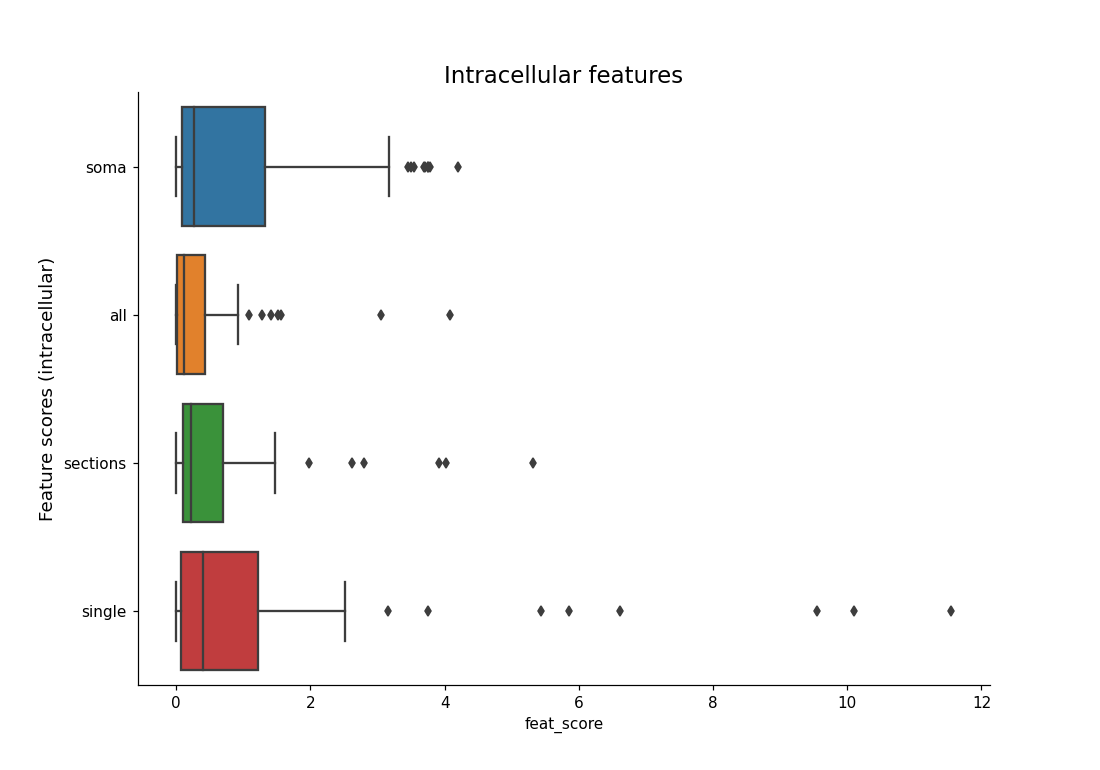

<IPython.core.display.Javascript object>


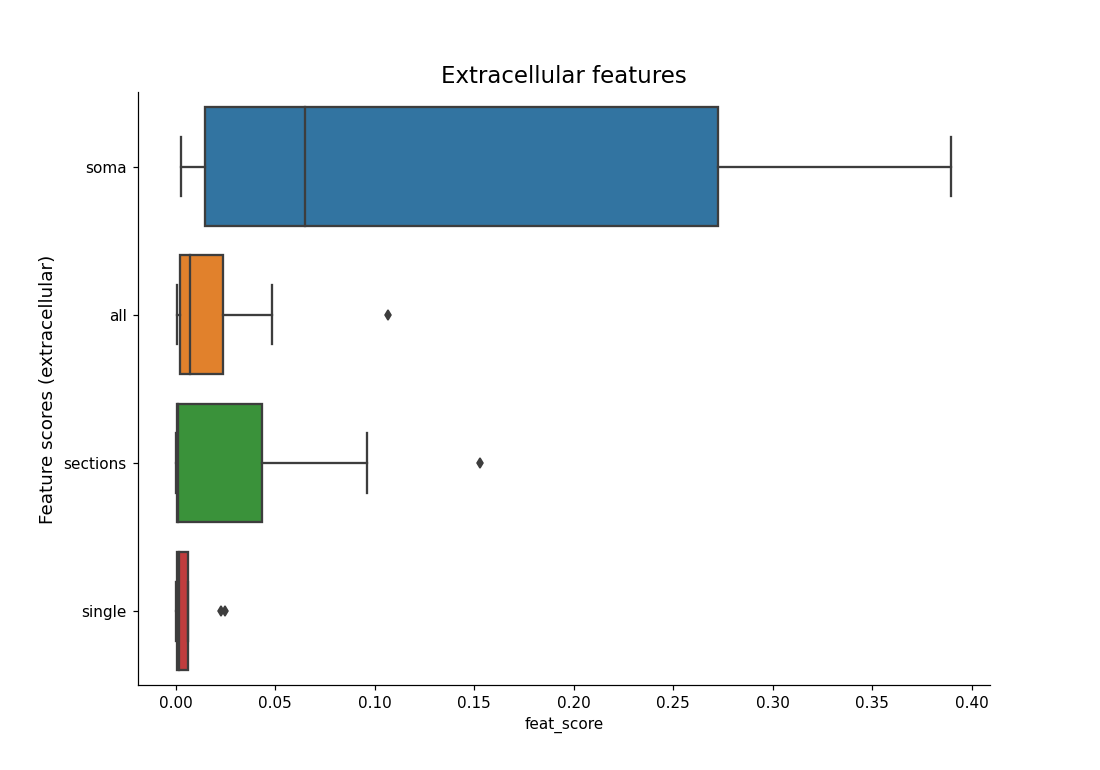

Text(0.5, 1.0, 'Extracellular features')

In [51]:
fig_feat_intra, ax = plt.subplots(figsize=figsize)

sns.boxplot(data=df_feats.query("feature_type == 'intra'"), y="feature_set", x="feat_score", 
            order=order, ax=ax)
ax.set_ylabel("Feature scores (intracellular)", fontsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Intracellular features", fontsize=15)

fig_feat_extra, ax = plt.subplots(figsize=figsize)

sns.boxplot(data=df_feats.query("feature_type == 'extra'"), 
            y="feature_set", x="feat_score", order=order, ax=ax)
ax.set_ylabel("Feature scores (extracellular)", fontsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Extracellular features", fontsize=15)


In [52]:
df_feats.query("feature_type == 'intra'").groupby("feature_set").sum()

feat_score
feature_set            
all           25.530147
sections      44.808688
single        89.908522
soma          66.580009

In [53]:
df_feats.query("feature_type == 'extra'").groupby("feature_set").sum()

feat_score
feature_set            
all            0.233486
sections       0.346761
single         0.068019
soma           1.604492

In [54]:
from scipy.stats import mannwhitneyu, wilcoxon

In [55]:
df_intra = df_feats.query("feature_type == 'intra'")
df_extra = df_feats.query("feature_type == 'extra'")

In [56]:
intra_soma = df_intra.query("feature_set == 'soma'")["feat_score"]
intra_sections = df_intra.query("feature_set == 'sections'")["feat_score"]
intra_all = df_intra.query("feature_set == 'all'")["feat_score"]
intra_single = df_intra.query("feature_set == 'single'")["feat_score"]

extra_soma = df_extra.query("feature_set == 'soma'")["feat_score"]
extra_sections = df_extra.query("feature_set == 'sections'")["feat_score"]
extra_all = df_extra.query("feature_set == 'all'")["feat_score"]
extra_single = df_extra.query("feature_set == 'single'")["feat_score"]

In [57]:
print("Intra - Sections VS SOMA:", wilcoxon(intra_sections, intra_soma))
print("Intra - All VS SOMA:", wilcoxon(intra_all, intra_soma))
print("Intra - Single VS SOMA:", wilcoxon(intra_single, intra_soma))
# print("Intra - All VS Sections:", wilcoxon(intra_sections, intra_all))

Intra - Sections VS SOMA: WilcoxonResult(statistic=982.0, pvalue=0.5542446082540099)
Intra - All VS SOMA: WilcoxonResult(statistic=318.0, pvalue=1.3764934960572389e-06)
Intra - Single VS SOMA: WilcoxonResult(statistic=738.0, pvalue=0.13611227313758487)


In [58]:
print("Extra - Sections VS SOMA:", wilcoxon(extra_sections, extra_soma))
print("Extra - All VS SOMA:", wilcoxon(extra_all, extra_soma))
print("Extra - Single VS SOMA:", wilcoxon(extra_single, extra_soma))
# print("Extra - All VS Sections:", wilcoxon(extra_sections, extra_all))

Extra - Sections VS SOMA: WilcoxonResult(statistic=0.0, pvalue=0.0009765625)
Extra - All VS SOMA: WilcoxonResult(statistic=1.0, pvalue=0.001953125)
Extra - Single VS SOMA: WilcoxonResult(statistic=0.0, pvalue=0.0009765625)


In [ ]:
if save_fig:
    fig_feat_intra.savefig(figure_folder / "feat_intra.pdf")
    fig_feat_extra.savefig(figure_folder / "feat_extra.pdf")

## Compare EAP distance

In [59]:
df_test["best_eap_dist"]

all         236.271905
sections    290.247651
single      211.525833
soma        749.325053
gt                 NaN
Name: best_eap_dist, dtype: float64

<IPython.core.display.Javascript object>


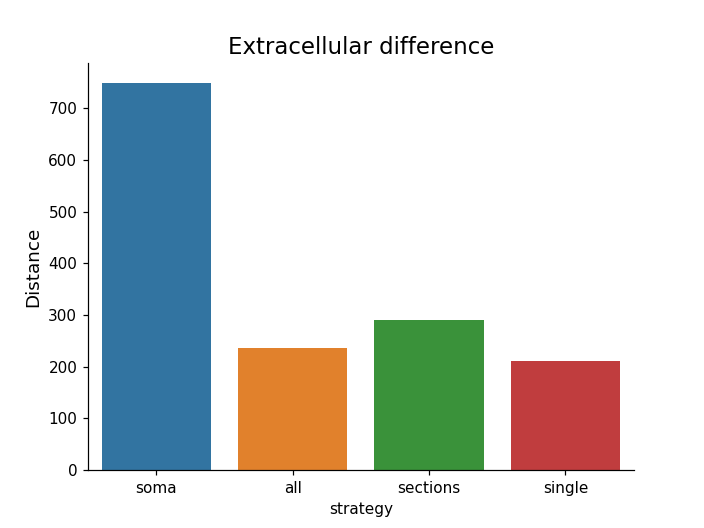

Text(0.5, 1.0, 'Extracellular difference')

In [60]:
fig_cos, ax = plt.subplots()
sns.barplot(data=df_test, x="strategy", y="best_eap_dist", order=order, ax=ax)
ax.set_ylabel("Distance", fontsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Extracellular difference", fontsize=15)

In [ ]:
if save_fig:
    fig_cos.savefig(figure_folder / "eap_dist.pdf")